In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set better visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [5]:
today = datetime.today().strftime('%Y-%m-%d')
start_date = '2024-01-01'

def fetch_stock_data(ticker_symbol, start_date=start_date, end_date=today):
    """Fetch stock data from yfinance"""
    print(f"Fetching data for {ticker_symbol} from {start_date} to {end_date}")
    stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return stock_data

In [6]:
# Specify ticker symbol (change as needed)
ticker = 'AAPL'  # Example: Apple Inc.
stock_data = fetch_stock_data(ticker)

# Display initial data overview
print("\nData Overview:")
display(stock_data.head())
print(f"\nTotal data points: {len(stock_data)}")

Fetching data for AAPL from 2024-01-01 to 2025-04-21
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Data Overview:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.532089,187.315382,182.792533,186.033072,82488700
2024-01-03,183.150360,184.770637,182.335247,183.120540,58414500
2024-01-04,180.824356,181.997307,179.800504,181.062914,71983600
2024-01-05,180.098694,181.669266,179.094727,180.903872,62303300
2024-01-08,184.452560,184.492330,180.416793,181.003268,59144500



Total data points: 325


In [7]:
def create_features(df):
    """Create technical features for the model"""
    # Make a copy of the dataframe to avoid modifying the original
    df_feat = df.copy()
    
    # Calculate moving averages
    df_feat['MA5'] = df['Close'].rolling(window=5).mean()
    df_feat['MA10'] = df['Close'].rolling(window=10).mean()
    df_feat['MA20'] = df['Close'].rolling(window=20).mean()
    
    # Calculate daily returns
    df_feat['Daily_Return'] = df['Close'].pct_change()
    
    # Calculate volatility (standard deviation over a window)
    df_feat['Volatility_5'] = df['Close'].rolling(window=5).std()
    df_feat['Volatility_10'] = df['Close'].rolling(window=10).std()
    
    # Calculate RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    df_feat['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD (Moving Average Convergence Divergence)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df_feat['MACD'] = exp1 - exp2
    df_feat['MACD_Signal'] = df_feat['MACD'].ewm(span=9, adjust=False).mean()
    
    # Day of week
    df_feat['DayOfWeek'] = pd.to_datetime(df.index).dayofweek
    
    # Target variable (next day's closing price)
    df_feat['Target'] = df['Close'].shift(-1)
    
    # Drop NaN values
    df_feat = df_feat.dropna()
    
    return df_feat

# Create features
df_features = create_features(stock_data)
print("\nFeatures created. Sample data:")
display(df_features.head())


Features created. Sample data:


Price,Close,High,Low,Open,Volume,MA5,MA10,MA20,Daily_Return,Volatility_5,Volatility_10,RSI,MACD,MACD_Signal,DayOfWeek,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2024-01-30,186.917755,190.655325,186.351165,189.800457,55859400,191.025101,190.138423,186.769152,-0.019246,2.570200,3.832766,55.832650,1.770270,1.514770,1,183.299484
2024-01-31,183.299484,185.983383,183.249795,185.923728,55467800,189.017157,190.309396,186.707522,-0.019358,3.892127,3.425555,46.739510,1.170903,1.445997,2,185.744812
2024-02-01,185.744812,185.834271,182.722962,182.891945,64885400,187.563882,190.133453,186.837244,0.013341,3.346287,3.625018,52.166522,0.883038,1.333405,3,184.740845
2024-02-02,184.740845,186.212008,178.180228,178.786588,102518000,186.257724,189.565863,187.033069,-0.005405,2.760544,4.000628,49.883324,0.567352,1.180194,4,186.559921
2024-02-05,186.559921,188.120559,184.730906,187.027118,69668800,185.452563,188.948572,187.356130,0.009847,1.466350,3.933343,56.857437,0.458665,1.035888,0,188.170242


In [9]:
def prepare_data(df_features):
    """Prepare features and target for training"""
    # Features for the model (drop the target and any non-feature columns)
    X = df_features.drop(['Target', 'Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
    y = df_features['Target']
    
    # Split the data
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, X.columns

X_train, X_test, y_train, y_test, scaler, feature_names = prepare_data(df_features)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (244, 10)
Test set shape: (61, 10)


In [10]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train and evaluate multiple models"""
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    }
    
    results = {}
    best_model = None
    best_score = float('inf')  # Using RMSE as metric, lower is better
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        
        # Store results
        results[name] = {
            'model': model,
            'predictions': y_pred,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
        
        # Track best model based on RMSE
        if rmse < best_score:
            best_score = rmse
            best_model = name
    
    print(f"\nBest model: {best_model} with RMSE: {results[best_model]['rmse']:.4f}")
    return results, best_model

results, best_model = train_and_evaluate_models(X_train, X_test, y_train, y_test)


Training Random Forest...
Random Forest - RMSE: 11.0868, MAE: 7.6413, R²: 0.5942

Training Decision Tree...
Decision Tree - RMSE: 14.9201, MAE: 10.9136, R²: 0.2651

Training XGBoost...
XGBoost - RMSE: 11.3431, MAE: 7.9619, R²: 0.5752

Best model: Random Forest with RMSE: 11.0868


In [11]:
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[model]['rmse'] for model in results],
    'MAE': [results[model]['mae'] for model in results],
    'R²': [results[model]['r2'] for model in results]
})
print("\nModel Comparison:")
display(performance_df.sort_values('RMSE'))


Model Comparison:


,Model,RMSE,MAE,R²
0,Random Forest,11.086848,7.641254,0.594218
2,XGBoost,11.343101,7.961884,0.575243
1,Decision Tree,14.920110,10.913573,0.265113


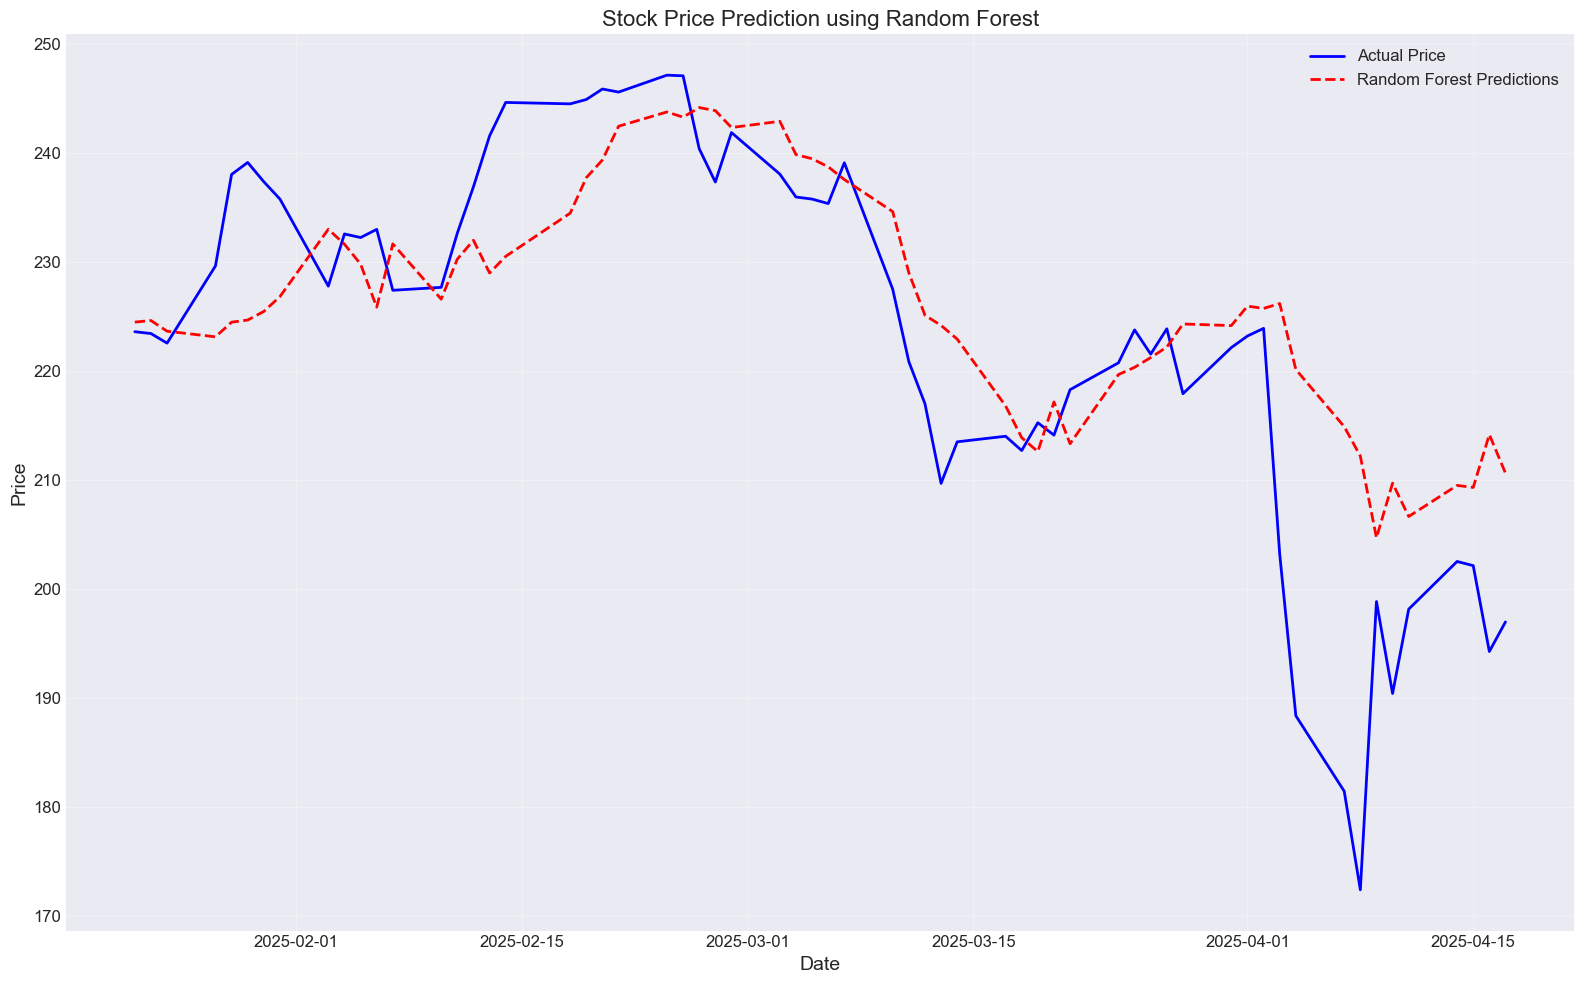

In [12]:
def plot_predictions(df, results, best_model):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(16, 10))
    
    # Plot actual prices
    pred_idx = df.index[-len(results[best_model]['predictions']):]
    actual_prices = df['Close'][-len(results[best_model]['predictions']):]
    
    plt.plot(pred_idx, actual_prices, 
             label='Actual Price', color='blue', linewidth=2)
    
    # Plot predictions
    plt.plot(pred_idx, results[best_model]['predictions'], 
             label=f'{best_model} Predictions', color='red', linestyle='--', linewidth=2)
    
    plt.title(f'Stock Price Prediction using {best_model}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_predictions(stock_data, results, best_model)

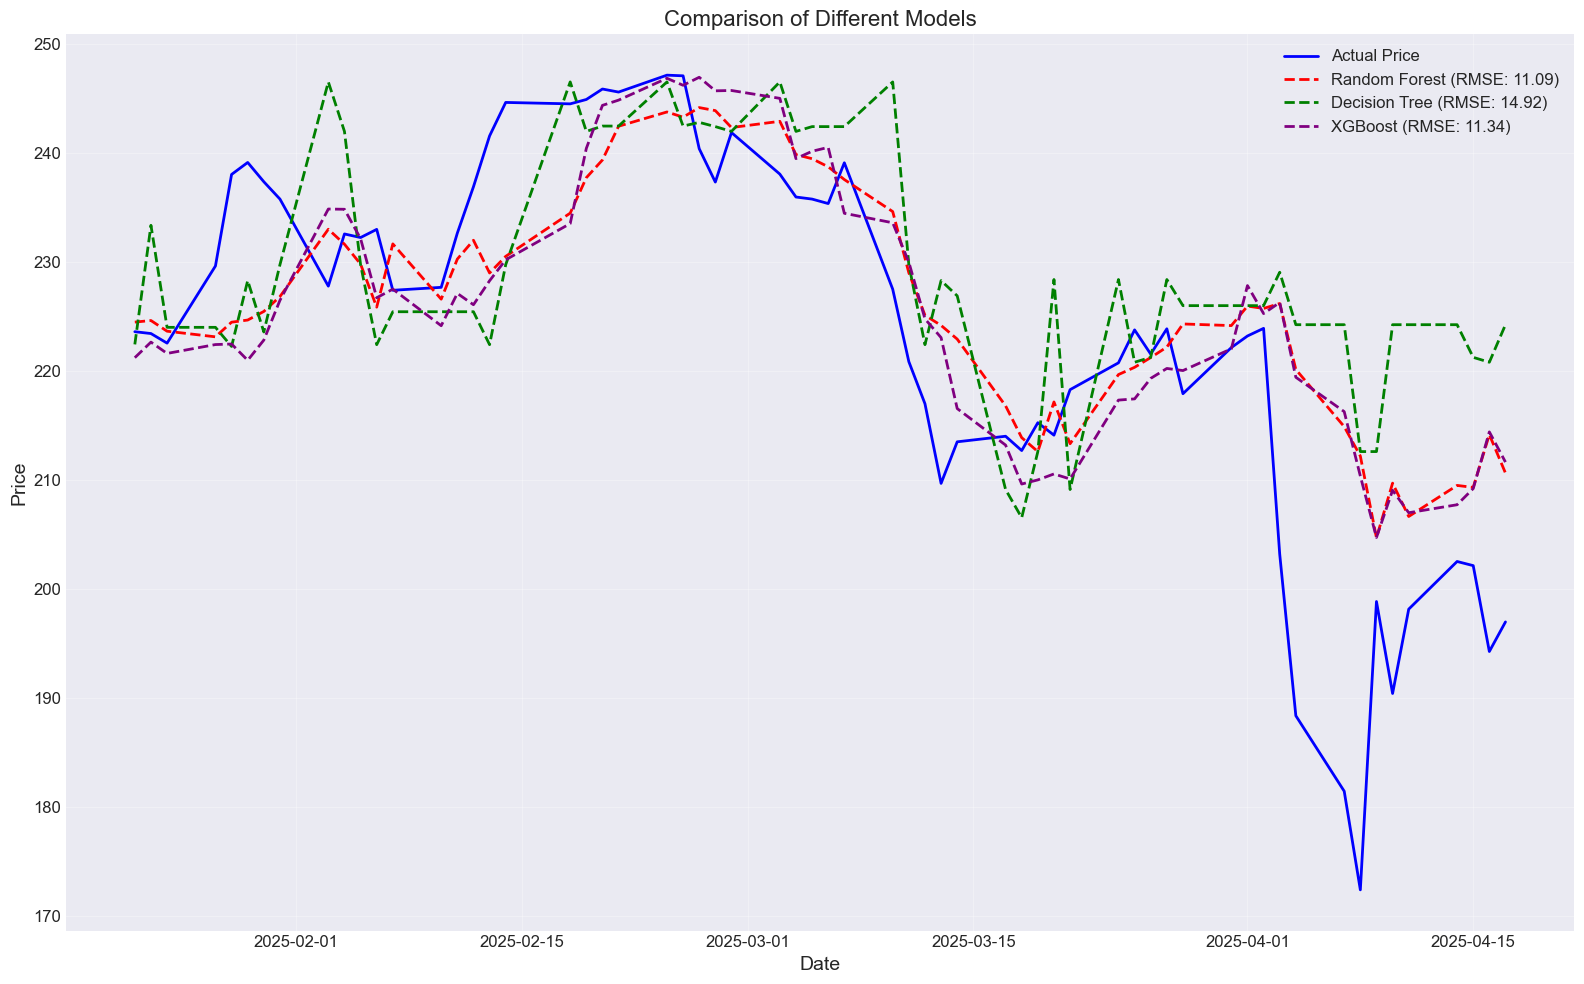

In [13]:
def plot_all_predictions(df, results):
    """Plot predictions from all models"""
    plt.figure(figsize=(16, 10))
    
    pred_idx = df.index[-len(results[best_model]['predictions']):]
    actual_prices = df['Close'][-len(results[best_model]['predictions']):]
    
    # Plot actual prices
    plt.plot(pred_idx, actual_prices, 
             label='Actual Price', color='blue', linewidth=2)
    
    # Plot all model predictions
    colors = ['red', 'green', 'purple']
    for i, (name, res) in enumerate(results.items()):
        plt.plot(pred_idx, res['predictions'], 
                 label=f'{name} (RMSE: {res["rmse"]:.2f})', 
                 color=colors[i], linestyle='--', linewidth=2)
    
    plt.title('Comparison of Different Models', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_all_predictions(stock_data, results)

In [30]:
import pickle

# Get the best model that you want to save
best_model_name = best_model
model_to_save = results[best_model_name]['model']  # This gets the actual model object

# Save the model using pickle
with open(f'stock_prediction_model.pkl', 'wb') as file:
    pickle.dump(model_to_save, file)

print(f"Model successfully saved as: stock_prediction_model.pkl")

Model successfully saved as: stock_prediction_model.pkl


In [26]:
import pickle

# Load the model
with open('stock_prediction_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Now you can use the loaded model to make predictions
predictions = loaded_model.predict(X_test)

FileNotFoundError: [Errno 2] No such file or directory: 'stock_prediction_Random Fo.pkl'